# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Section 4. 

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU. 

In [2]:
print("Using torch ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)    
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x) 
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x) 
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch  2.5.1
tensor([1.], device='mps:0')
MPS (MacBook) device found.
Number of MPS cards:  1
Total MPS memory 11.45 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model. 

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size = 256 # adapted to the Google Colab GPU
learning_rate = 0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

We analyse the data to check the number of samples and their size.

In [441]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article. 

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. 

In [442]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()        
        
        self.first_layer = nn.Linear(input_size, hidden_sizes[0])        
        self.hidden_layers = nn.Sequential()
        for i in range(len(hidden_sizes)-1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.outpout_layer = nn.Linear(hidden_sizes[-1], output_size)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):  #original x shape [batch_size, 1, image_size, image_size]
        x = torch.flatten(x, start_dim=1)    #new x shape [batch_size, image_size * image_size]
        x = self.first_layer(x)
        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i](x)
        x = self.outpout_layer(x)
        return self.softmax(x)

**Question**: Create one of the model proposed in the article.

In [443]:
input_size = 784
hidden_sizes = [128]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (first_layer): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layers): Sequential()
  (outpout_layer): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [444]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [445]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)
      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [446]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 1.5795
Epoch [1/5], Step [200/235], Loss: 1.5675
Epoch [2/5], Step [100/235], Loss: 1.5640
Epoch [2/5], Step [200/235], Loss: 1.5186
Epoch [3/5], Step [100/235], Loss: 1.5458
Epoch [3/5], Step [200/235], Loss: 1.5411
Epoch [4/5], Step [100/235], Loss: 1.5344
Epoch [4/5], Step [200/235], Loss: 1.5400
Epoch [5/5], Step [100/235], Loss: 1.5569
Epoch [5/5], Step [200/235], Loss: 1.5640


In [447]:
evaluation(model, test_loader)

Accuracy of test images: 92.910000 %


Hyperparameters grid search

In [160]:
from itertools import product

hidden_sizes_list = [[128], [512], [256, 128], [512, 256, 128]]
weight_decay_list = [0, 1e-4, 1e-5]
num_epochs_list = [5, 20]
batch_size_list = [256]
learning_rate_list = [0.001, 0.0001]

hyperparameter_combinations = list(product(hidden_sizes_list, weight_decay_list, num_epochs_list, batch_size_list, learning_rate_list))


for hidden_sizes, weight_decay, num_epochs, batch_size, learning_rate in hyperparameter_combinations:
    print(f"Training with hidden_sizes={hidden_sizes}, weight_decay={weight_decay}, num_epochs={num_epochs}, batch_size={batch_size}, learning_rate={learning_rate}")

    train_loader  = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
    model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    training(model, train_loader, optimizer, num_epochs, loss_model)
    
    evaluation(model, test_loader)

Training with hidden_sizes=[128], weight_decay=0, num_epochs=5, batch_size=256, learning_rate=0.001
Epoch [1/5], Step [100/235], Loss: 1.6196
Epoch [1/5], Step [200/235], Loss: 1.5683
Epoch [2/5], Step [100/235], Loss: 1.5523
Epoch [2/5], Step [200/235], Loss: 1.5507
Epoch [3/5], Step [100/235], Loss: 1.5467
Epoch [3/5], Step [200/235], Loss: 1.5474
Epoch [4/5], Step [100/235], Loss: 1.5308
Epoch [4/5], Step [200/235], Loss: 1.5446
Epoch [5/5], Step [100/235], Loss: 1.5426
Epoch [5/5], Step [200/235], Loss: 1.5351
Accuracy of test images: 92.560000 %
Training with hidden_sizes=[128], weight_decay=0, num_epochs=5, batch_size=256, learning_rate=0.0001
Epoch [1/5], Step [100/235], Loss: 2.1322
Epoch [1/5], Step [200/235], Loss: 1.8751
Epoch [2/5], Step [100/235], Loss: 1.7500
Epoch [2/5], Step [200/235], Loss: 1.7422
Epoch [3/5], Step [100/235], Loss: 1.6442
Epoch [3/5], Step [200/235], Loss: 1.6389
Epoch [4/5], Step [100/235], Loss: 1.6125
Epoch [4/5], Step [200/235], Loss: 1.6003
Epoch 

**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model. 

**Answer**: The performance are good but not perfect: the network can reach around 92% of accuracy on the test set. However, as said in introduction, it's possible to reach an accuracy of 97% on the MNIST test set. The "Occam's razor principle" stipulates that for two models with similar performance, the simplest one (fewer layers, fewer epochs or no weight decay for example) should be selected. This will notably limit overfitting. Following this idea, I have chosen the following parameters for the network: hidden_sizes = [128], weight_decay = 0, num_epochs = 5 and learning_rate = 0.001, this gives an accuracy of 92,56%. This is not the better accuracy but it's not far from the best and the model is very simple.

Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [454]:
weight_decay = 0
num_epochs = 5
batch_size = 256 # adapted to the Google Colab GPU
learning_rate = 0.001

input_size = 784
hidden_sizes = [128]
output_size = 10

# Model
default_model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(default_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Training
train_loader  = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
training(default_model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 1.6056
Epoch [1/5], Step [200/235], Loss: 1.5644
Epoch [2/5], Step [100/235], Loss: 1.5576
Epoch [2/5], Step [200/235], Loss: 1.5218
Epoch [3/5], Step [100/235], Loss: 1.5477
Epoch [3/5], Step [200/235], Loss: 1.5534
Epoch [4/5], Step [100/235], Loss: 1.5375
Epoch [4/5], Step [200/235], Loss: 1.5130
Epoch [5/5], Step [100/235], Loss: 1.5326
Epoch [5/5], Step [200/235], Loss: 1.5637


In [455]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=600
initial_c = 0.0000001  # Initial value of c
max_c = 0.5  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 200  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

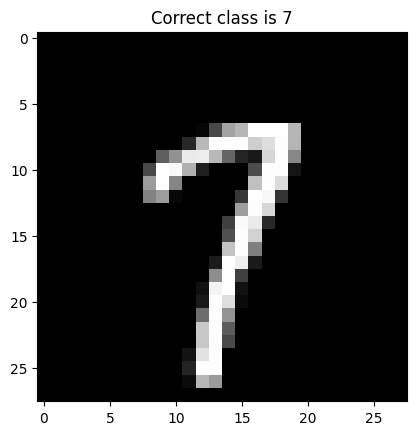

In [456]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [457]:
def plot_results(X, r, Xr, Y, l, fail=True):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)    
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 7, the new class will be 9
Found c = 0.000000 satisfying f(x + r) = l
Optimization succeeded with c = 0.00000011 in 3 iterations
Norm Perturbation |r|: 22.496902465820312


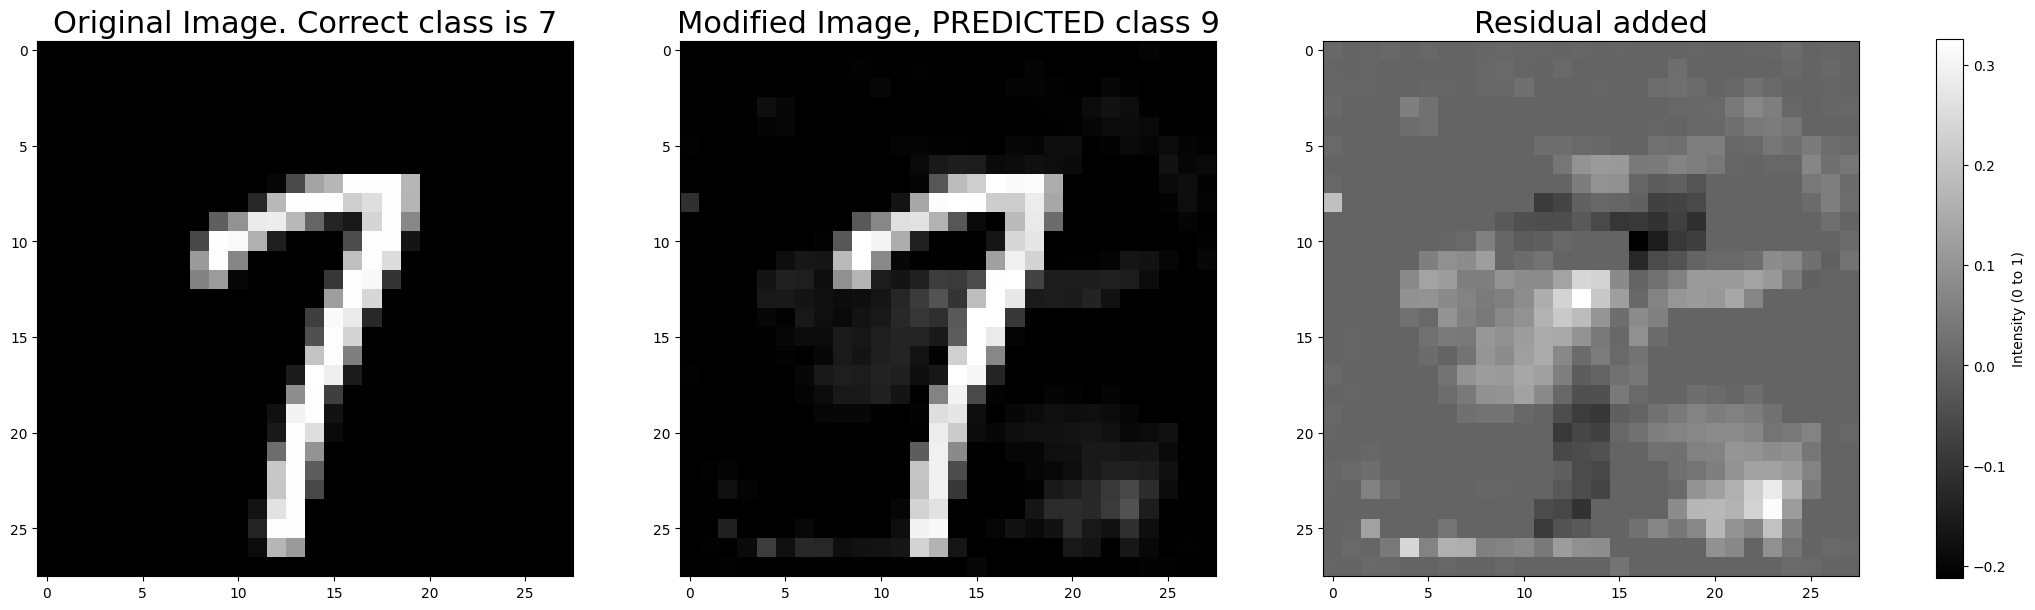

In [458]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label = 9 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    pred_class = default_model(torch.clamp(x+r, 0, 1))
    loss_f = loss_model(pred_class, l)
    return c * torch.norm(r, p=2) + loss_f


# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):    
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r], lr_LBFGS, max_iter=max_iter_LBFGS, tolerance_change=epsilon_LBFGS)

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = default_model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        break

    # If not satisfied, increase c
    c *= mult_c # Adjust step size for line search
    iter=iter+1
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.8f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ?

**Answer**: The algorithm seems not to always converge. For example with image index 669, and a predicted class of 8, the algorithm doesn't converge within the limit of c and max number of iteration. In fact, it seems to be uncommon that the algorithm converge with the default parameters of c and max_iter. However, for example for image with index 668, and a predicted class of 9, the algorithm converge. As we can see on the 3 images above, the new image is semantically similar to the original one: indeed we also recognise the number 7 even if some perturbation are added. Therefore, images should belong to the original class. In this case, the average distortion is equal to 21.7.

**Question** What if you try with different networks ? Test with at least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed. 

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

In [459]:
weight_decay = 0
num_epochs = 5
batch_size = 256 # adapted to the Google Colab GPU
learning_rate = 0.001

input_size = 784
hidden_sizes = [256, 64]
output_size = 10

# Model
new_model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Training
train_loader  = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
training(new_model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 1.5908
Epoch [1/5], Step [200/235], Loss: 1.5557
Epoch [2/5], Step [100/235], Loss: 1.5397
Epoch [2/5], Step [200/235], Loss: 1.5395
Epoch [3/5], Step [100/235], Loss: 1.5249
Epoch [3/5], Step [200/235], Loss: 1.5517
Epoch [4/5], Step [100/235], Loss: 1.5173
Epoch [4/5], Step [200/235], Loss: 1.5145
Epoch [5/5], Step [100/235], Loss: 1.5538
Epoch [5/5], Step [200/235], Loss: 1.5522


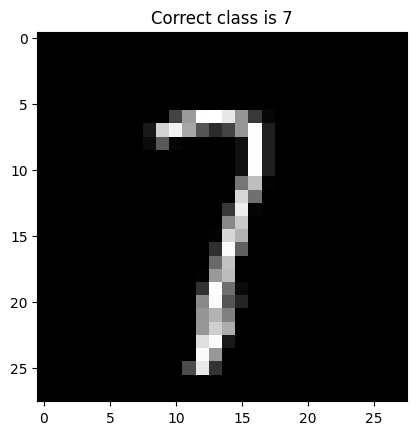

In [460]:
# Parameters adversarial example
index=667 # index test image to use

max_iter_search=600
initial_c = 0.0000001  # Initial value of c
max_c = 0.5  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 200  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

The true class is 7, the new class will be 1
Found c = 0.00000010 satisfying f(x + r) = l
Optimization succeeded with c = 0.00000010 in 0 iterations
Norm Perturbation |r|: 23.396373748779297


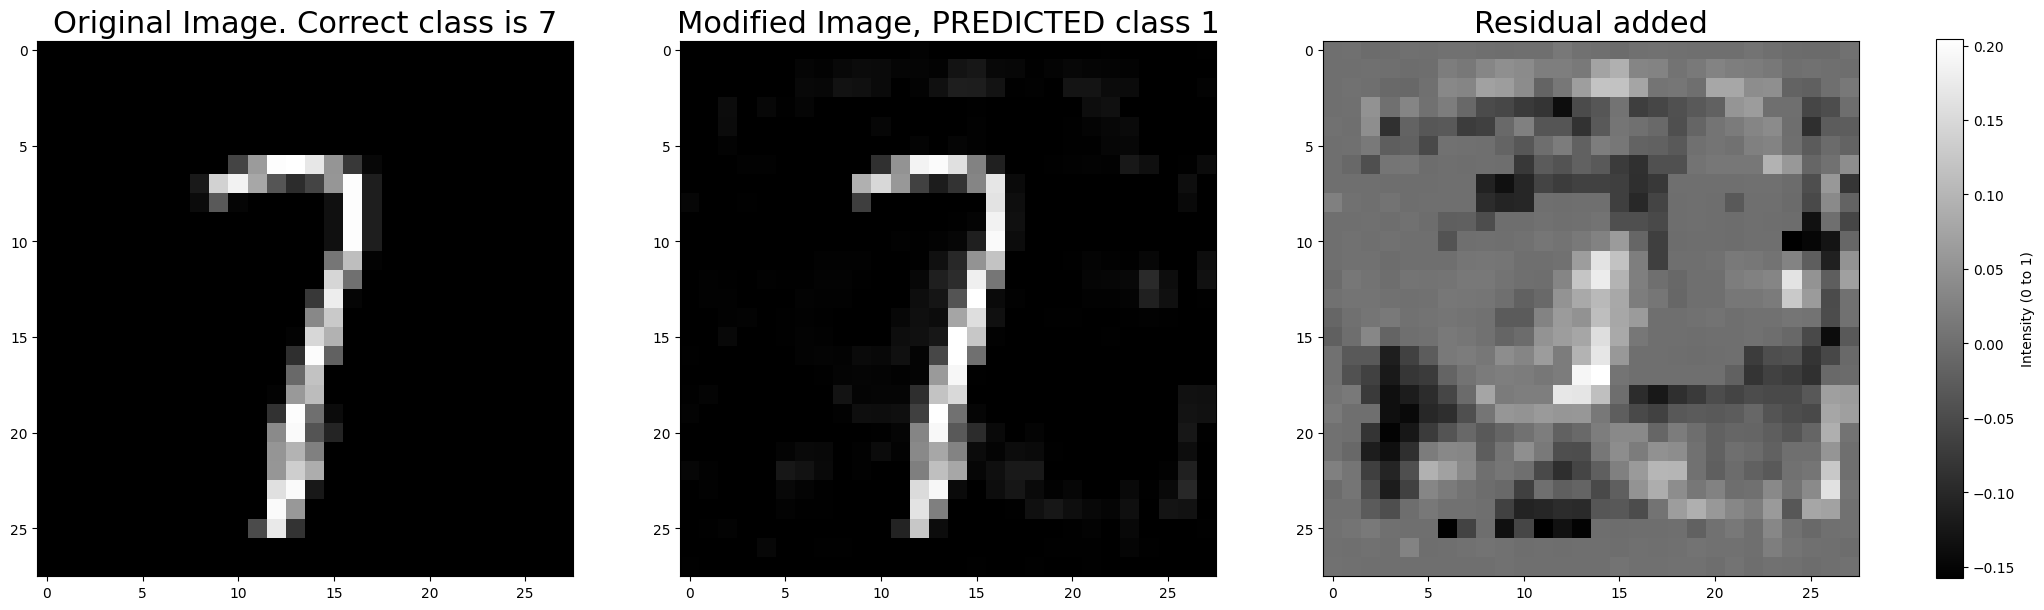

In [461]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label = 1 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    pred_class = new_model(torch.clamp(x+r, 0, 1))
    loss_f = loss_model(pred_class, l)
    return c * torch.norm(r, p=2) + loss_f


# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):    
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r], lr_LBFGS, max_iter=max_iter_LBFGS, tolerance_change=epsilon_LBFGS)

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = new_model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.8f} satisfying f(x + r) = l")
        break

    # If not satisfied, increase c
    c *= mult_c # Adjust step size for line search
    iter=iter+1
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.8f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.8f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

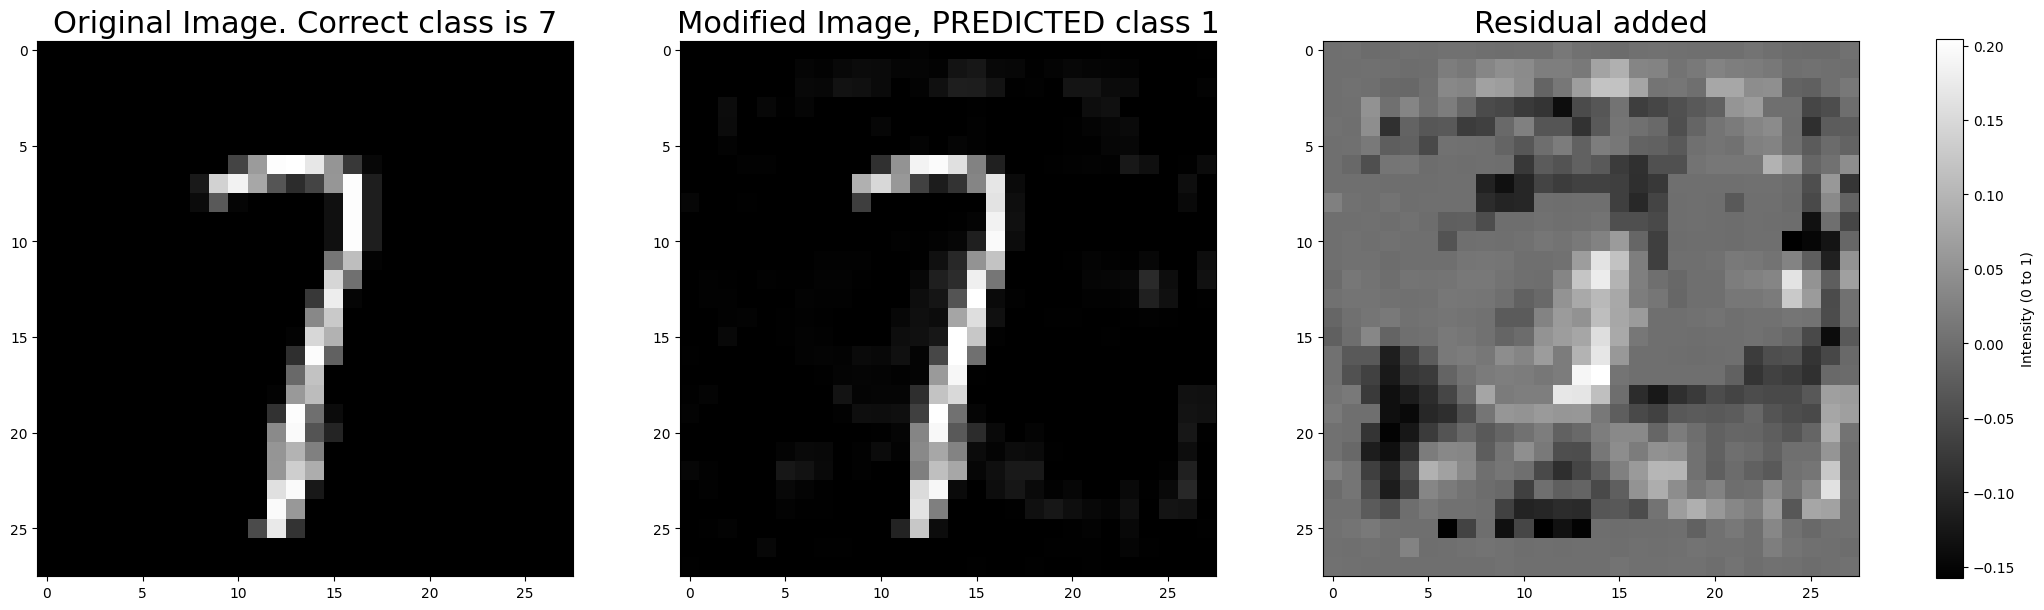

In [463]:
pred = default_model(x_r)
predicted_label = torch.argmax(pred, dim=1)
plot_results(testI, r, x_r, testY, predicted_label, fail=False)

**Answer**: Here we just changed the architecture of our network by changing hidden_sizes from [128] to [256, 64]. The previous conclusion seems to be confirmed by this other architecture. The algorithm doesn't always converge, the new image is semantically similar to the original one: indeed we also recognise the number 7 even if some perturbation are added. Therefore, images should belong to the original class. This time wo obtained an average distortion of 27.31, which is the same order of magnitude as before. 

In the case just above, the two networks are wrongly predicting the class of the "noisy" version of the original image. From these results we can conclude that even if neural networks can have good accuracy results on a classification task, it can be more difficult if the input images are a bit perturbed: in this case neural networks have more difficulties to capture the semantic/global information to classify it correctly. It suggests that the deep neural networks that are learned by backpropagation have non-intuitive characteristics and intrinsic blind spots, whose structure is connected to the data distribution
in a non-obvious way.

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c. 

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Please comment on that.

In [464]:
weight_decay = 0
num_epochs = 5
batch_size = 256 # adapted to the Google Colab GPU
learning_rate = 0.001

input_size = 784
hidden_sizes = [128]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Training
train_loader  = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 1.6116
Epoch [1/5], Step [200/235], Loss: 1.5295
Epoch [2/5], Step [100/235], Loss: 1.5435
Epoch [2/5], Step [200/235], Loss: 1.5410
Epoch [3/5], Step [100/235], Loss: 1.5190
Epoch [3/5], Step [200/235], Loss: 1.5639
Epoch [4/5], Step [100/235], Loss: 1.5315
Epoch [4/5], Step [200/235], Loss: 1.5382
Epoch [5/5], Step [100/235], Loss: 1.5138
Epoch [5/5], Step [200/235], Loss: 1.5328


1. Fixed c value

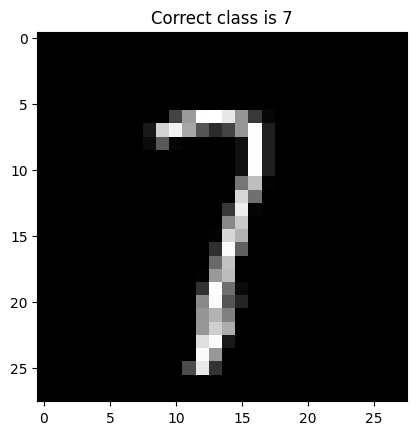

In [465]:
# Parameters adversarial example
index=667 # index test image to use
initial_c = 0.00001 
lr_Adam = 0.0001  # Learning rate for Adam
max_iter_search = 600

testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

The true class is 7, the new class will be 2
Iter 0/600, Loss: 2.45522904
Iter 20/600, Loss: 2.45191383
Iter 40/600, Loss: 2.44654560
Iter 60/600, Loss: 2.43782544
Iter 80/600, Loss: 2.42369008
Iter 100/600, Loss: 2.40106392
Iter 120/600, Loss: 2.36553431
Iter 140/600, Loss: 2.31165409
Iter 160/600, Loss: 2.23398757
Iter 180/600, Loss: 2.13205504
Successfully found adversarial example at iteration 191
Optimization succeeded with c = 0.00001000
Norm Perturbation |r|: 7.571941375732422


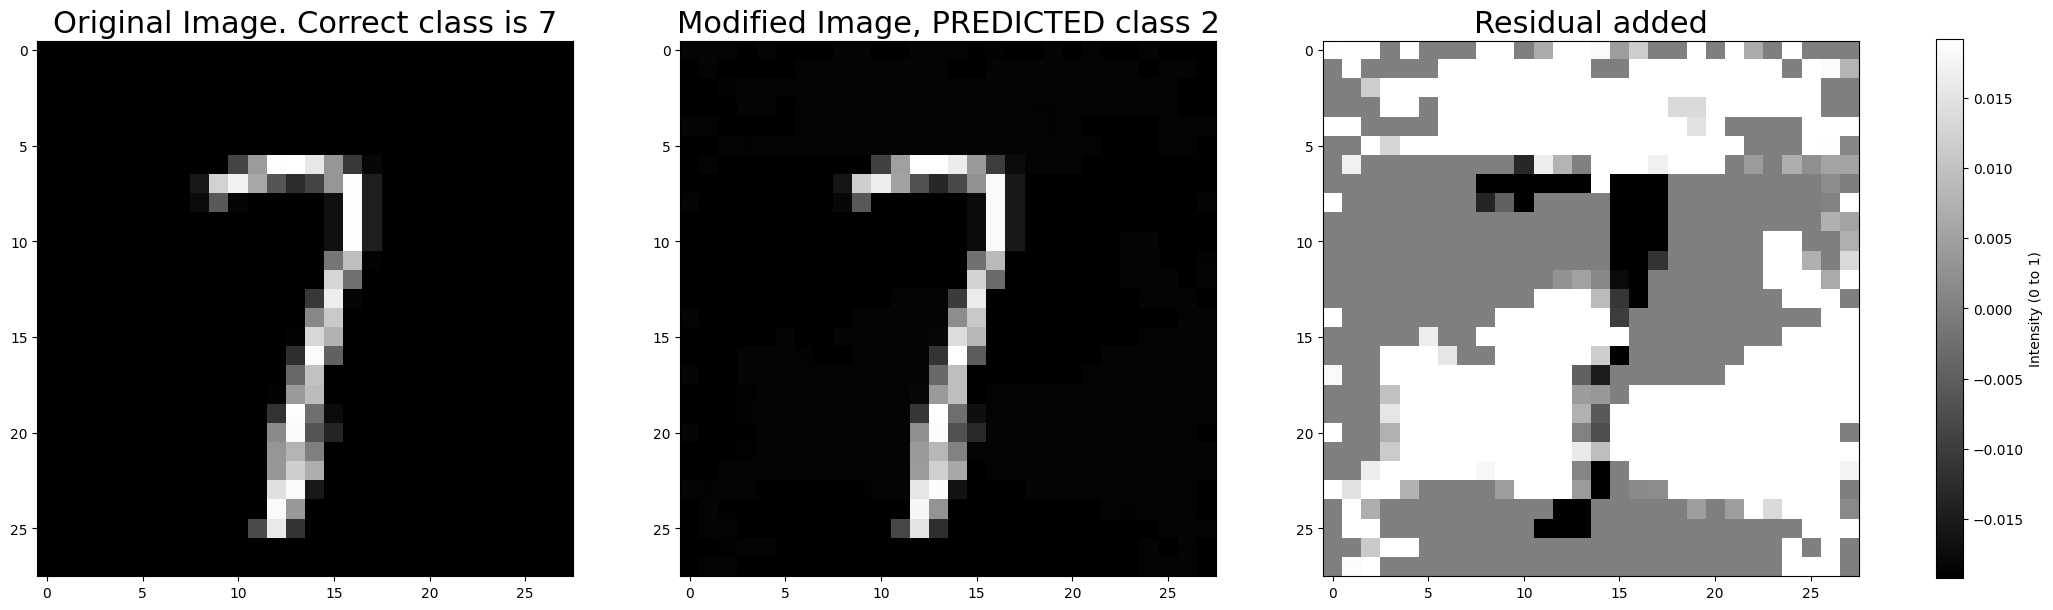

In [466]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label = 2 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")

def objective(c, r, x, l, lambda_reg=0.01):
    pred_class = model(torch.clamp(x+r, 0, 1))
    loss_f = loss_model(pred_class, l)
    return c * torch.norm(r, p=2) + loss_f

c = initial_c
for iter in range(max_iter_search):    
    # Define the optimizer
    optimizerAdam = optim.Adam([r], lr_Adam)
    loss = objective(c, r, testI, l)
    optimizerAdam.zero_grad()
    loss.backward()
    
    # Perform optimization
    optimizerAdam.step()

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Successfully found adversarial example at iteration {iter}")
        break

    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Loss: {loss.item():.8f}')
        
with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

if predicted_label == l:
    print(f"Optimization succeeded with c = {c:.8f}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=False)
    
else:
    print("Failed to find adversarial example.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)

2. Estimated c value


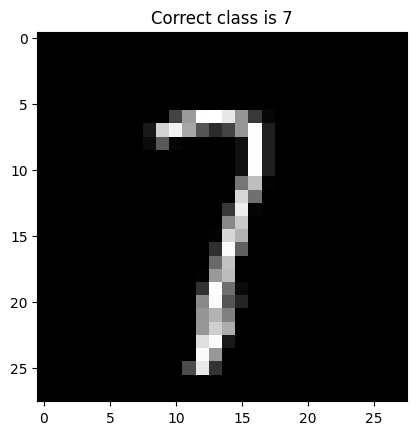

In [467]:
# Parameters adversarial example
index=667 # index test image to use
lr_Adam = 0.0001  # Learning rate for Adam
max_iter_search = 600

testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

The true class is 7, the new class will be 2
Iter 0/600, Loss: 2.45522904
Iter 20/600, Loss: 2.45522952
Iter 40/600, Loss: 2.45522952
Iter 60/600, Loss: 2.45522952
Iter 80/600, Loss: 2.45522952
Iter 100/600, Loss: 2.45522952
Iter 120/600, Loss: 2.45522952
Iter 140/600, Loss: 2.45522952
Iter 160/600, Loss: 2.45522952
Iter 180/600, Loss: 2.45522952
Iter 200/600, Loss: 2.45522952
Iter 220/600, Loss: 2.45522952
Iter 240/600, Loss: 2.45522952
Iter 260/600, Loss: 2.45522952
Iter 280/600, Loss: 2.45522952
Iter 300/600, Loss: 2.45522952
Iter 320/600, Loss: 2.45522952
Iter 340/600, Loss: 2.45522952
Iter 360/600, Loss: 2.45522952
Iter 380/600, Loss: 2.45522952
Iter 400/600, Loss: 2.45522952
Iter 420/600, Loss: 2.45522952
Iter 440/600, Loss: 2.45522952
Iter 460/600, Loss: 2.45522952
Iter 480/600, Loss: 2.45522952
Iter 500/600, Loss: 2.45522952
Iter 520/600, Loss: 2.45522952
Iter 540/600, Loss: 2.45522952
Iter 560/600, Loss: 2.45522952
Iter 580/600, Loss: 2.45522952
Iter 600/600, Loss: 2.45522952


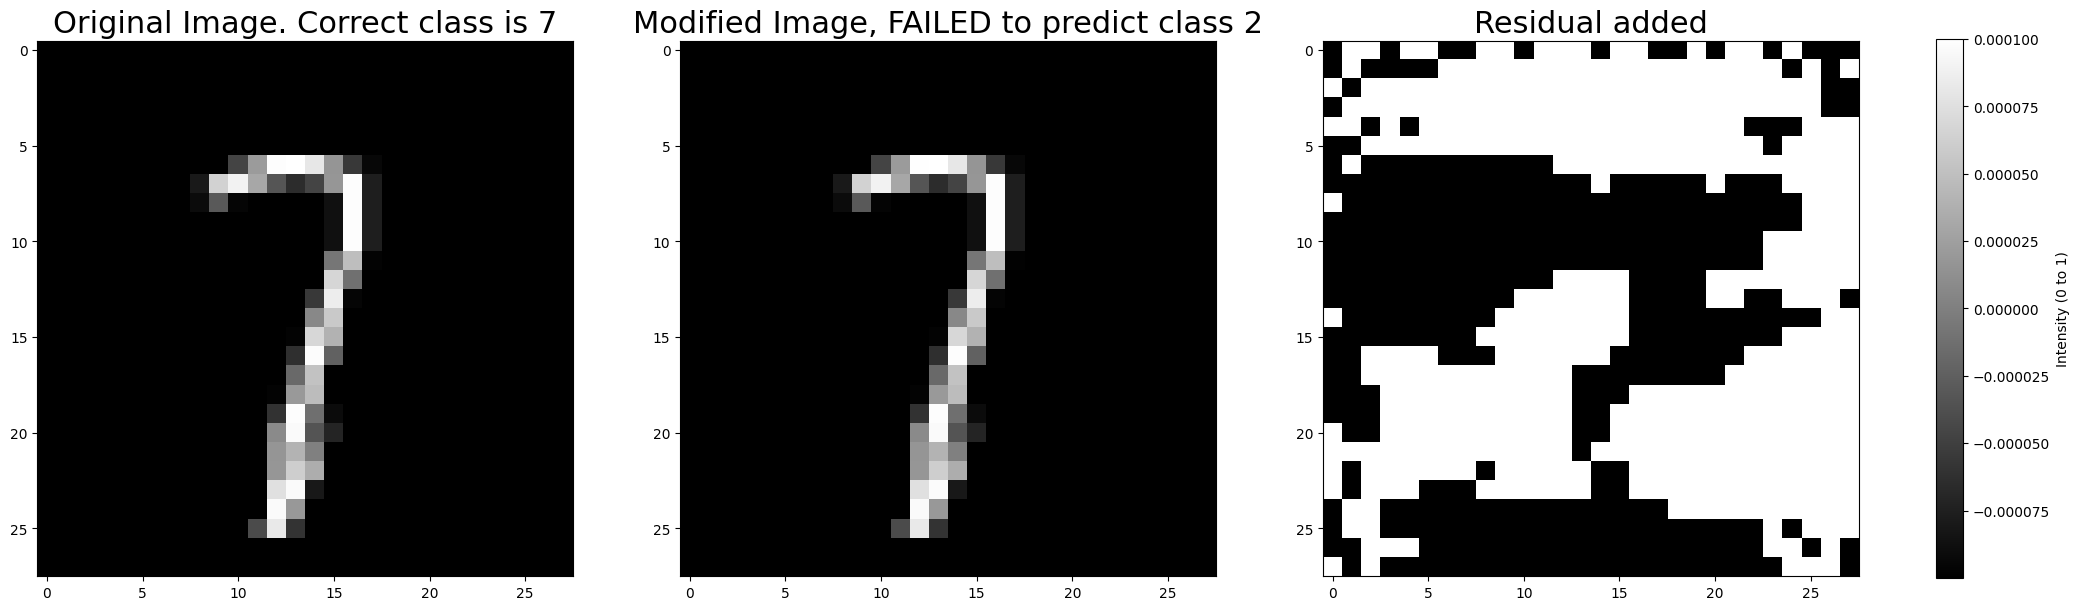

In [471]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
c = torch.tensor([0.01], requires_grad=True, device=device)  # Start with an initial c value

label = 2 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)  
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")

def objective(c, r, x, l, lambda_reg=0.0001):
    pred_class = model(torch.clamp(x+r, 0, 1))
    loss_f = loss_model(pred_class, l)
    regularization_term = lambda_reg * torch.norm(r, p=1)
    return c * torch.norm(r, p=2) + loss_f + regularization_term

for iter in range(max_iter_search+1): 
    # Ensure c stays positive
    c_positive = torch.nn.functional.softplus(c)
    # Define the optimizer
    optimizerAdam = optim.Adam([r, c], lr_Adam)
    loss = objective(c_positive, r, testI, l)
    optimizerAdam.zero_grad()
    loss.backward()
    
    # Perform optimization
    optimizerAdam.step()


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Successfully found adversarial example at iteration {iter}")
        break

    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Loss: {loss.item():.8f}')
        
with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

if predicted_label == l:
    print(f"Optimization succeeded with c = {c.item():.8f}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=False)
    
else:
    print("Failed to find adversarial example.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)

It seems to work correctly in the first case when we estimate only r. In the case when we try to estimate both r and c, I didn't manage to make it works: I tried both with and without regularization term. I tried both L1 or L2 regularization but it didn't works. It shows that the Adam optimizer is maybe not the best candidate to produce adversarial examples by minimizing the last loss.

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [472]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

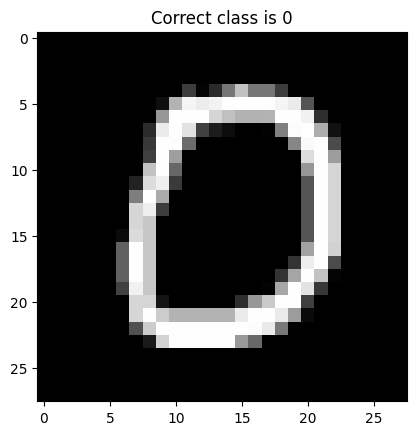

In [473]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 0, Perturbed Class: 0
Optimization failed
Norm Perturbation |r|: 7.840000152587891


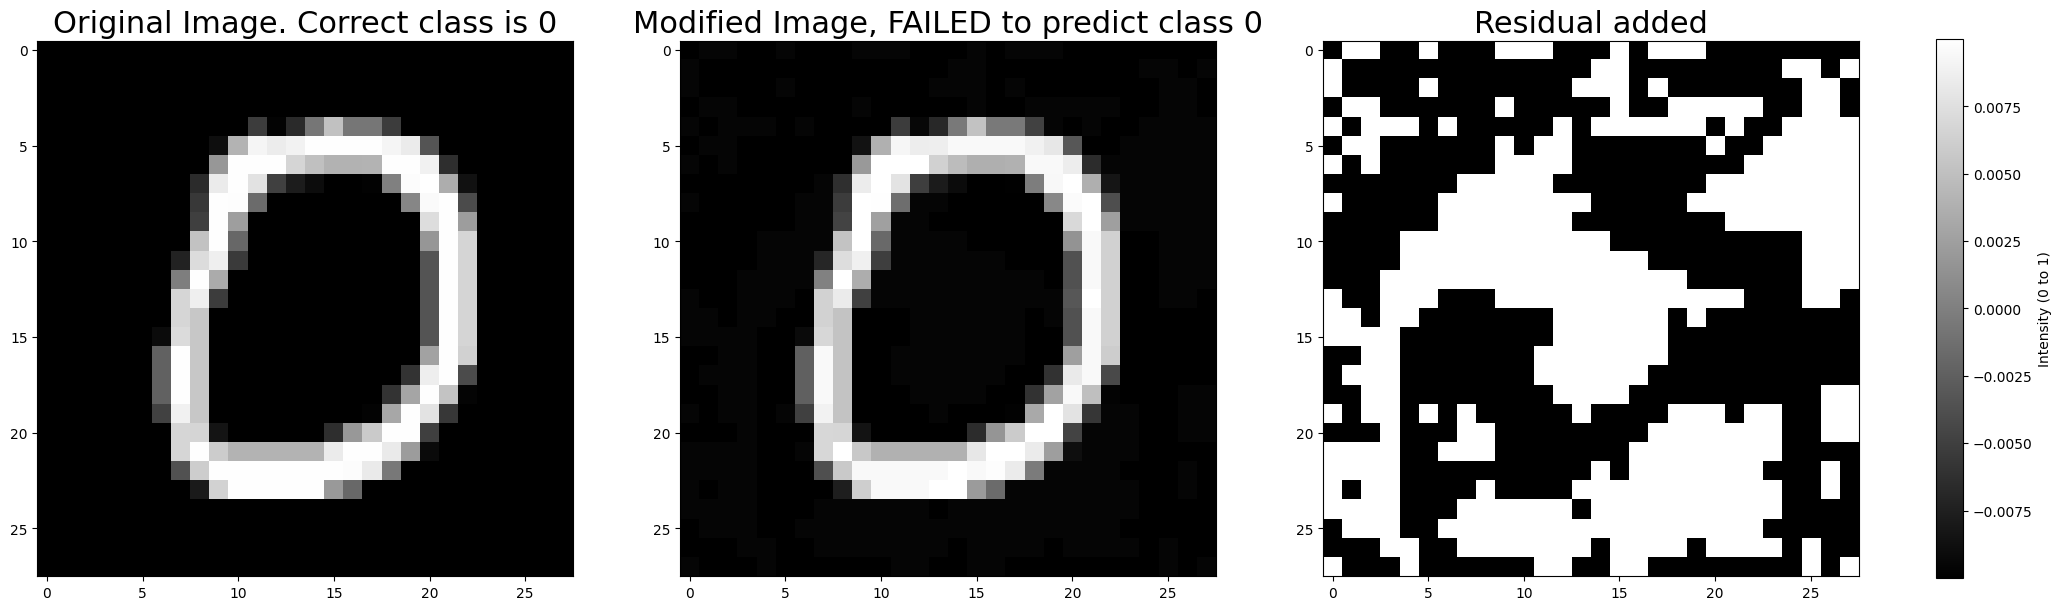

In [474]:
eps = 0.01 # perturbation size

# Forward pass of X through the model
pred_original = model(X)  
original_class = Y

# Compute loss
cost = loss_model(pred_original, original_class)

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = X + eps*X.grad.data.sign()

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class=torch.argmax(pred_perturbed,dim=1)    

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

r=eps*X.grad.data.sign()

if original_class.item()==perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)   
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created). 

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Using epsilon: 1 we successfully create 99.92999999999999 % adversarial examples


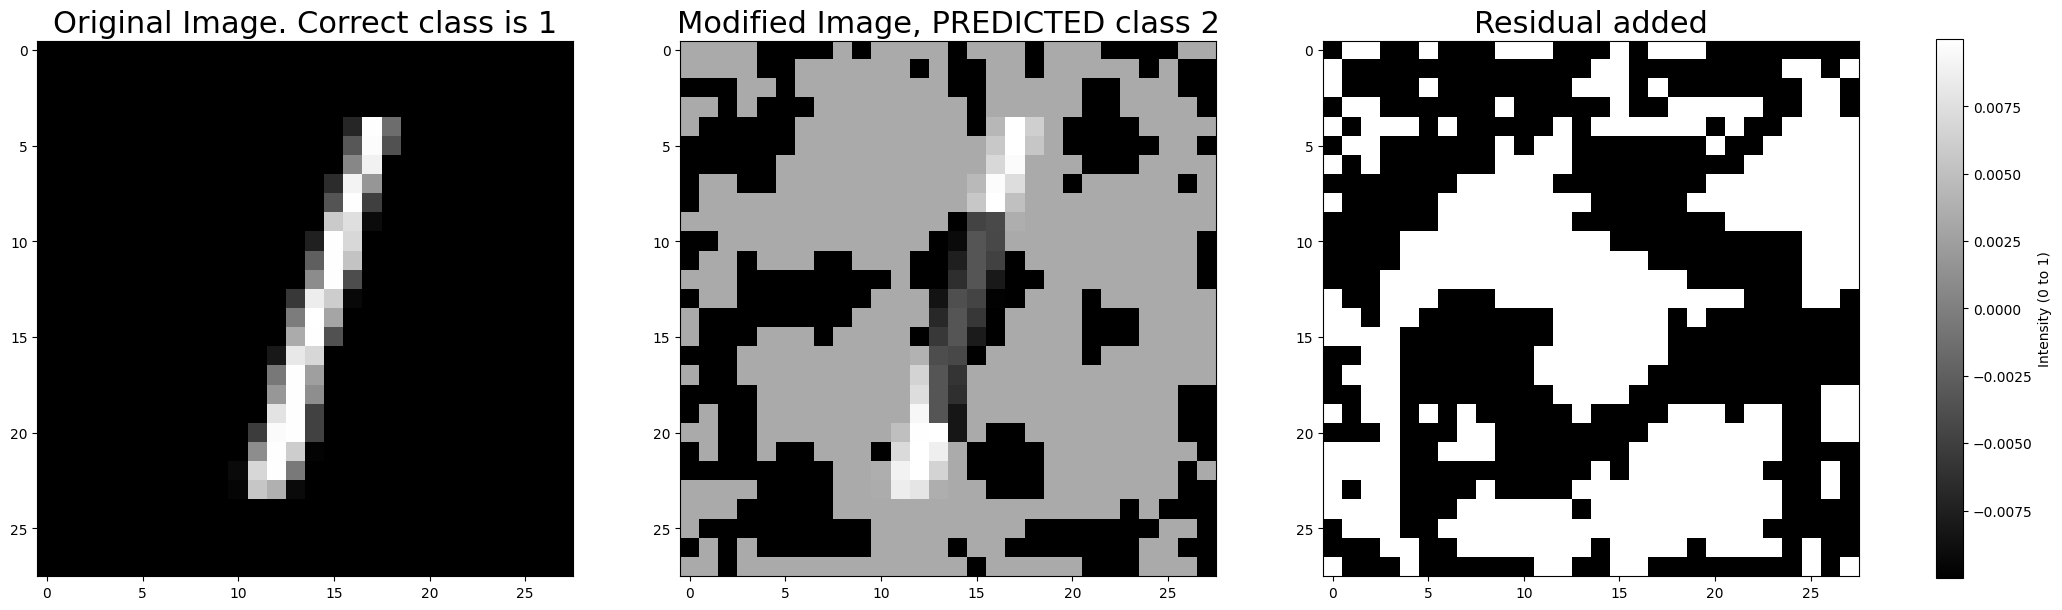

In [475]:
def fgsm_attack(X, Y, model, loss_model, eps):
    # Forward pass of X through the model
    pred_original = model(X)  
    original_class = Y
    
    # Compute loss
    cost = loss_model(pred_original, original_class)
    
    # Zero existing (previous) gradients
    model.zero_grad()
    
    # Compute gradients
    cost.backward()
    
    # FGSM attack code
    Xr = X + eps*X.grad.data.sign()
    
    # Re-classify the perturbed image
    pred_perturbed = model(Xr)
    perturbed_class=torch.argmax(pred_perturbed,dim=1)   

    return Xr, original_class, perturbed_class, r

# Accuracy counter
adv_examples = []
success = 0
total = 0
eps = 1 # perturbation size

# Loop over all examples in test set
for X_batch, Y_batch in test_loader:  # Iterate through batches
    for X, Y in zip(X_batch, Y_batch):
        X = X.unsqueeze(0).to(device)
        X.requires_grad = True
        Y = Y.unsqueeze(0).to(device)
        
        Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)
        # Check if the original and perturbed images are classified differently
        if original_class.item() != perturbed_class.item():
            success += 1 
            adv_examples.append((X.detach(), r.detach(), Xr.detach(), Y, perturbed_class))
        total += 1

# Calculate final accuracy for this epsilon
Adv_acc = success/total * 100
print(f"Using epsilon: {eps} we successfully create {Adv_acc} % adversarial examples")   

# Plot one example
index=2
plot_results(adv_examples[index][0], adv_examples[index][1], adv_examples[index][2], adv_examples[index][3].item(), adv_examples[index][4], fail=False)

The best epsilon seems to be 1, indeed in this case we get almost 100% of adversarial examples created. In this case, the changes are perceptible for a human eye as we can see above. However, if we choose a lower value for epsilon it still can generate adversarial examples (less in proportion) but this time the changes are imperceptible by a human eye: see below for epsilon = 0.01.

Using epsilon: 0.01 we successfully create 14.71 % adversarial examples


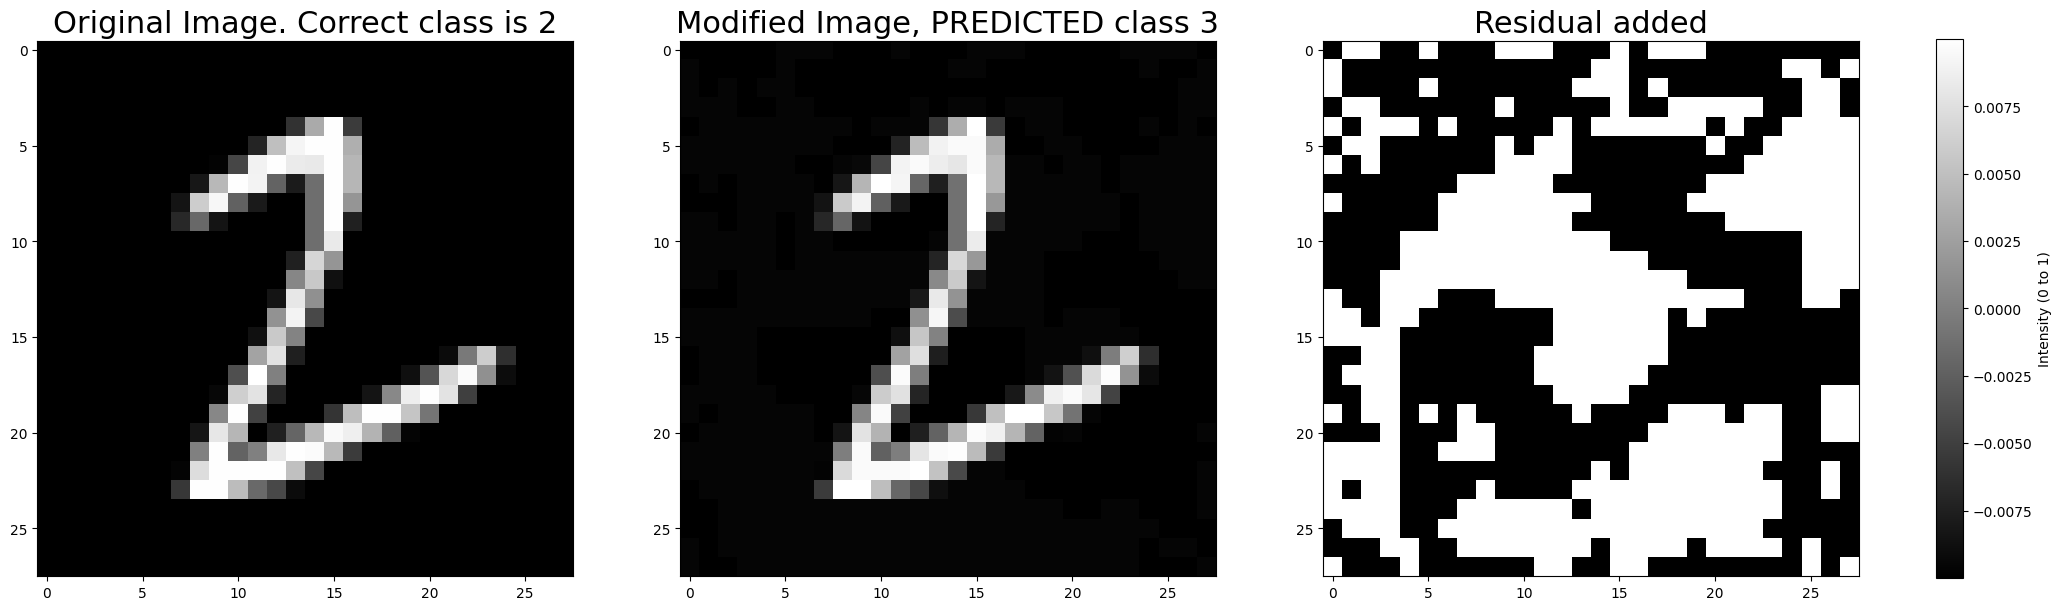

In [476]:
def fgsm_attack(X, Y, model, loss_model, eps):
    # Forward pass of X through the model
    pred_original = model(X)  
    original_class = Y
    
    # Compute loss
    cost = loss_model(pred_original, original_class)
    
    # Zero existing (previous) gradients
    model.zero_grad()
    
    # Compute gradients
    cost.backward()
    
    # FGSM attack code
    Xr = X + eps*X.grad.data.sign()
    
    # Re-classify the perturbed image
    pred_perturbed = model(Xr)
    perturbed_class=torch.argmax(pred_perturbed,dim=1)   

    return Xr, original_class, perturbed_class, r

# Accuracy counter
adv_examples = []
success = 0
total = 0
eps = 0.01 # perturbation size

# Loop over all examples in test set
for X_batch, Y_batch in test_loader:  # Iterate through batches
    for X, Y in zip(X_batch, Y_batch):
        X = X.unsqueeze(0).to(device)
        X.requires_grad = True
        Y = Y.unsqueeze(0).to(device)
        
        Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)
        # Check if the original and perturbed images are classified differently
        if original_class.item() != perturbed_class.item():
            success += 1 
            adv_examples.append((X.detach(), r.detach(), Xr.detach(), Y, perturbed_class))
        total += 1

# Calculate final accuracy for this epsilon
Adv_acc = success/total * 100
print(f"Using epsilon: {eps} we successfully create {Adv_acc} % adversarial examples")   

# Plot one example
index=2
plot_results(adv_examples[index][0], adv_examples[index][1], adv_examples[index][2], adv_examples[index][3].item(), adv_examples[index][4], fail=False)